In [1]:
# ============================================================
# WEEK 3: Skin Cancer and Pneumonia Detection
# With Kaggle Dataset Download
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import shutil
import zipfile

SEED = 42
IMG_SIZE = (128, 128)
BATCH_SIZE = 32



In [2]:
!pip install kaggle -q
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehwishnasir","key":"9aa79437c925736460594cf500daf934"}'}

In [3]:
# ============================================================
# Kaggle API Setup
# ============================================================
# Make sure your kaggle.json is uploaded first
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [4]:
# ============================================================
# Download Skin Cancer Dataset (ISIC 2019 - binary subset)
# ============================================================
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ./data
!unzip -qo ./data/skin-cancer-mnist-ham10000.zip -d ./data/skin_cancer

# Download Pneumonia Dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./data
!unzip -qo ./data/chest-xray-pneumonia.zip -d ./data/pneumonia


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:25<00:00, 36.6MB/s]
100% 5.20G/5.20G [01:25<00:00, 65.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 265MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


In [5]:
# ============================================================
# Utility: ROC Curve
# ============================================================
def plot_roc(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()


In [6]:
# ============================================================
# PART A: Skin Cancer Detection
# ============================================================

# Prepare train/val/test folders manually (using HAM10000 dataset)
import pandas as pd
df = pd.read_csv("./data/skin_cancer/HAM10000_metadata.csv")

# Binary split: melanocytic nevus (nv) = 0, melanoma (mel) = 1
df = df[df["dx"].isin(["nv","mel"])]
df["label"] = df["dx"].map({"nv":0, "mel":1})

# Copy images into split folders
base_dir = "data/skin_cancer_split"
for split in ["train","val","test"]:
    for cls in ["0","1"]:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

train_df, test_df = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=SEED)
train_df, val_df  = train_test_split(train_df, stratify=train_df["label"], test_size=0.2, random_state=SEED)

def copy_images(dataframe, split):
    for _, row in dataframe.iterrows():
        img_id, label = row["image_id"], str(row["label"])
        src = f"./data/skin_cancer/HAM10000_images_part_1/{img_id}.jpg"
        if not os.path.exists(src):
            src = f"./data/skin_cancer/HAM10000_images_part_2/{img_id}.jpg"
        dst = os.path.join(base_dir, split, label, f"{img_id}.jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")

# Generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_directory(base_dir+"/train", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True, seed=SEED)
val_flow   = val_gen.flow_from_directory(base_dir+"/val",   target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)
test_flow  = test_gen.flow_from_directory(base_dir+"/test", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)


Found 5003 images belonging to 2 classes.
Found 1251 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.


In [7]:
# Build Transfer Learning Model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False
model_skin = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model_skin.compile(optimizer=keras.optimizers.Adam(1e-4),
                   loss="binary_crossentropy", metrics=["accuracy"])

history_skin = model_skin.fit(train_flow, validation_data=val_flow, epochs=8)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 327ms/step - accuracy: 0.7879 - loss: 0.5041 - val_accuracy: 0.8577 - val_loss: 0.4107
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.8547 - loss: 0.4297 - val_accuracy: 0.8577 - val_loss: 0.4093
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 254ms/step - accuracy: 0.8567 - loss: 0.4252 - val_accuracy: 0.8577 - val_loss: 0.4070
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - accuracy: 0.8543 - loss: 0.4311 - val_accuracy: 0.8577 - val_loss: 0.4072
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.8679 - loss: 0.3997 - val_accuracy: 0.8577 - val_loss: 0.4054
Epoch 6/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - accuracy: 0.8562 - loss: 0.4161 - val_accuracy: 0.8577 - val_loss: 0.4045
Epoch 7/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.8657 - loss: 0.4034 - val_accuracy: 0.8577 - val_loss: 0.4034
Epoch 8/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 252ms/step - accuracy: 0.8548 - loss: 0.4141 - 

49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step

[Skin Cancer] Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      1341
           1       0.00      0.00      0.00       223

    accuracy                           0.86      1564
   macro avg       0.43      0.50      0.46      1564
weighted avg       0.74      0.86      0.79      1564

Confusion Matrix:
 [[1341    0]
 [ 223    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


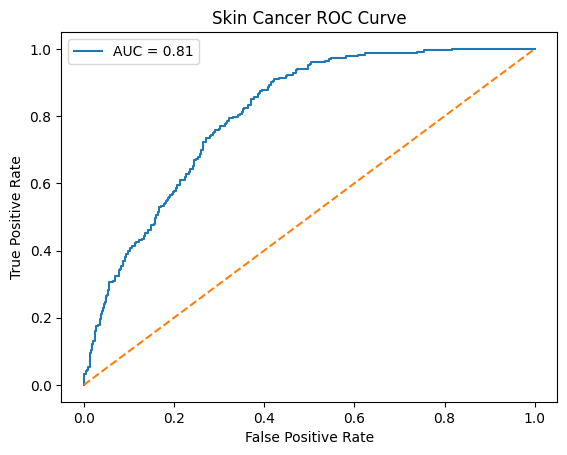

In [8]:
# Evaluation
y_prob_skin = model_skin.predict(test_flow).ravel()
y_pred_skin = (y_prob_skin >= 0.5).astype(int)
y_true_skin = test_flow.classes
print("\n[Skin Cancer] Report:\n", classification_report(y_true_skin, y_pred_skin))
print("Confusion Matrix:\n", confusion_matrix(y_true_skin, y_pred_skin))
plot_roc(y_true_skin, y_prob_skin, "Skin Cancer ROC Curve")


In [33]:
PNEUMONIA_DATASET_DIR = "data/pneumonia/chest_xray/chest_xray"

# Train + Validation generator (with split)
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% images for validation
)

# Train set
train_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

# Validation set
val_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

# Test set
test_gen = ImageDataGenerator(rescale=1./255)
test_flow_p = test_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 776 images belonging to 1 classes.
Found 194 images belonging to 1 classes.
Found 624 images belonging to 2 classes.


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generators with validation split
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% images for validation
)

test_gen = ImageDataGenerator(rescale=1./255)

# Training split
train_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",   # important
    shuffle=True,
    seed=SEED
)

# Validation split
val_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",  # important
    shuffle=False,
    seed=SEED
)

# Test data
test_flow_p = test_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 776 images belonging to 1 classes.
Found 194 images belonging to 1 classes.
Found 624 images belonging to 2 classes.


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import os

# ==========================================================
# Data Augmentation (Strong)
# ==========================================================
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest"
)

test_gen = ImageDataGenerator(rescale=1./255)

# Train split
train_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

# Validation split
val_flow_p = train_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

# Test
test_flow_p = test_gen.flow_from_directory(
    os.path.join(PNEUMONIA_DATASET_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 776 images belonging to 1 classes.
Found 194 images belonging to 1 classes.
Found 624 images belonging to 2 classes.


In [68]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class weights calculate
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_flow.classes),
    y=train_flow.classes
)
class_weights = dict(enumerate(class_weights))


In [72]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Load pretrained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False   # Freeze convolutional base

# Build classifier on top
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# Compile with small LR
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

# Train
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 372ms/step - accuracy: 0.8146 - loss: 0.4865 - val_accuracy: 0.8633 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 2/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.8463 - loss: 0.4125 - val_accuracy: 0.8745 - val_loss: 0.3138 - learning_rate: 1.0000e-04
Epoch 3/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.8669 - loss: 0.3537 - val_accuracy: 0.8761 - val_loss: 0.2944 - learning_rate: 1.0000e-04
Epoch 4/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.8607 - loss: 0.3531 - val_accuracy: 0.8809 - val_loss: 0.2798 - learning_rate: 1.0000e-04
Epoch 5/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.8583 - loss: 0.3333 - val_accuracy: 0.8849 - val_loss: 0.2718 - learning_rate: 1.0000e-04
Epoch 6/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - accuracy: 0.8657 - loss: 0.3381 - val_accuracy: 0.8849 - val_loss: 0.2664 - learning_rate: 1.0000e-

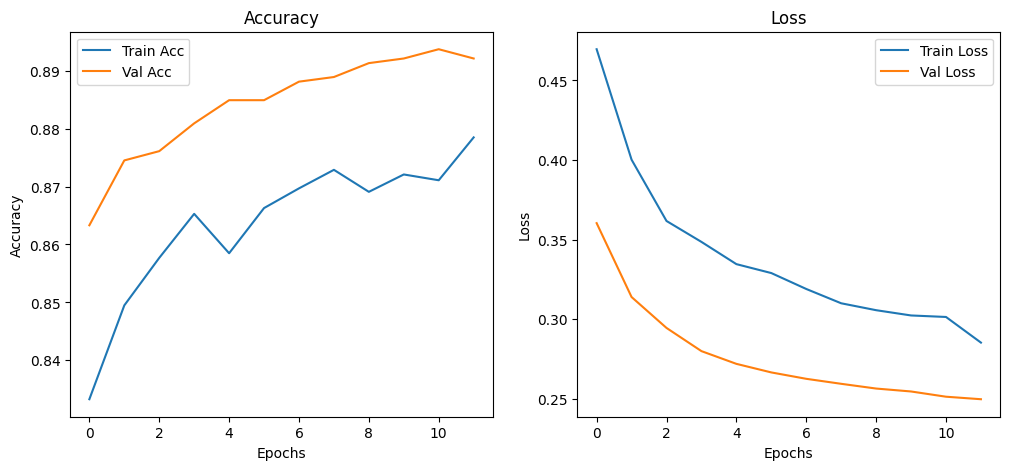

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# ---- Accuracy & Loss Graphs ----
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step


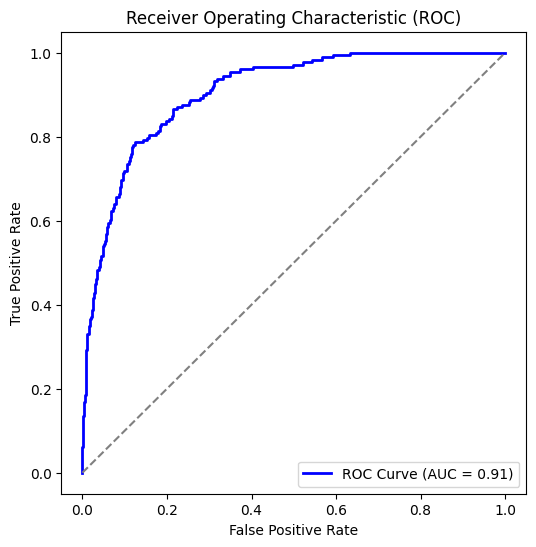

In [75]:
# ---- ROC Curve ----
# Get predictions on validation set
y_true = val_flow.classes   # true labels
y_pred = model.predict(val_flow).ravel()  # predicted probabilities

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()
